<a href="https://colab.research.google.com/github/NatalyaEvans/ETNP_stoich/blob/main/pyompa_scripts/ETNP_pyompa_for_WOD_full_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Perform an OMP on the ETNP ODZ data from the WOD18 to determine variations in the stoichiometry of anaerobic remineralization

Reference for Evans et al: https://aslopubs.onlinelibrary.wiley.com/doi/abs/10.1002/lno.11412
Add other references

This version finds the mean value around a region of water mass endmembers using remineralization.

To do:
Set up a better sensitivity function to do this
Remove the weighting sensitivity
Put the sensitivity code into a new file that you can load in with github

Comment the shit out of this


Fix the water types with 13CW po4=2.355 and put this spreadsheet up, then when this runs, it should give the soln needed

Install pyompa and gsw

In [86]:
!pip install pyompa==0.4.2.0
!pip install gsw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Mount the google drive folder


In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
%cd "/content/drive/MyDrive/pyompa/ETNP WOD pyompa"
!ls

/content/drive/MyDrive/pyompa/ETNP WOD pyompa
endmember_sensitivity_fns.ipynb
ETNP_df_ompasoln.csv
ETNP_pyompa_for_WOD_full_version.ipynb
ETNP_pyompa_for_WOD_USER_FRIENDLY_BASE_VERSION.ipynb
ETNP_pyompa_for_WOD_with_weightings_sensitivity.ipynb
ETNP_pyompa_ref_values.csv
param_weightings_sensitivity
pyompa_basis.m
pyompa_plotter_reox.m
sampled_weightings.json
scratch
WOD_cleaned.csv
WOD_ETNP_pyompa_2.csv
WOD_ETNP_pyompa_2_reduced.csv



Load the input data

In [89]:
import scipy.io
from scipy.io import loadmat
import pandas as pd
import numpy as np
import json
from collections import OrderedDict

# # csv style
# inp_df = pd.read_csv("WOD_ETNP_pyompa_2.csv")

# inp_df = inp_df.rename(columns={'Potential Density Anomaly ~$s~#~_0 [kg/m~^3]': 'pdens','Absolute Salinity S~_A [g/kg]': 'SA', 'Conservative Temperature ~$Q~# [degC]': 'CT',
#                                 'Nitrate [~$m~#mol/kg]': 'Nitrate', 'Phosphate [~$m~#mol/kg]': 'Phosphate', 'Silicate [~$m~#mol/kg]': 'Silicate', 'tCO~_2 [mmol/l]': 'tCO2'})

# #Filter the data frame to density ranges used for intermedite waters
# data_df = pd.DataFrame(
#    inp_df[(inp_df["pdens"] >= 26.4)
#               & (inp_df["pdens"] <= 27.3)])
# data_df.size


In [90]:
# data_df.columns
# data_df["tCO2"]=1000*data_df["tCO2"]*(1000/(1000+data_df["pdens"]))
# data_df["Nstar"]=data_df["Nitrate"]-16*data_df["Phosphate"]
# data_df=data_df.drop(data_df[data_df["Nstar"]>-5.75].index)
# data_df=data_df.drop(data_df[data_df["Nstar"]+2.25*data_df["Phosphate"]+0.5275>0].index)
# data_df=data_df.drop(data_df[data_df["Longitude [degrees_east]"]<-115].index)
# data_df.to_csv("WOD_ETNP_pyompa_2_reduced.csv")
# data_df.size

In [91]:
data_df = pd.read_csv("WOD_ETNP_pyompa_2_reduced.csv")

Define the end-members. Column headers here have to match those of the observations pandas

In [92]:
endmembers_df_read = pd.read_csv("ETNP_pyompa_ref_values.csv")


In [93]:
endmembers_df_read.head()

Params      CT     SA  Phosphate  Nitrate  Silicate  tCO2  pdens  \
0   13CW  13.410  34.95      2.355    31.20     25.40  2247  26.29   
1  NEPIW   9.470  34.78      2.650    35.60     33.86  2270  26.74   
2   AAIW   5.530  34.70      3.130    43.21     83.68  2323  27.25   
3  uPSUW   7.765  32.96      1.130    10.07     11.40  2235  25.60   

                                               Notes  
0  Adjusted to a more centered point in intersection  
1                                                NaN  
2  Shifted to on the intersection, rather than th...  
3                                                NaN

Remove the non-water types from the endmembers

In [94]:
endmembers_df = endmembers_df_read.iloc[[0,1,2]] # use uPSUW or no fourth

endmembers_df.head()

Params     CT     SA  Phosphate  Nitrate  Silicate  tCO2  pdens  \
0   13CW  13.41  34.95      2.355    31.20     25.40  2247  26.29   
1  NEPIW   9.47  34.78      2.650    35.60     33.86  2270  26.74   
2   AAIW   5.53  34.70      3.130    43.21     83.68  2323  27.25   

                                               Notes  
0  Adjusted to a more centered point in intersection  
1                                                NaN  
2  Shifted to on the intersection, rather than th...

Define the pyompa parameters to replicate the matlab OMP analysis, and run the analysis

In [95]:
import pyompa
from pyompa.endmemberpenaltyfunc import GeneralPenaltyFunc

convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="aerobic_remin",
        conversion_ratios=[{"Phosphate": 1.0, "Nitrate": 14, "Silicate": 12, "tCO2": 98},
        {"Phosphate": 1.0, "Nitrate": 17, "Silicate": 48, "tCO2": 118}],
        always_positive=False 
        ),pyompa.ConvertedParamGroup(
        groupname="anaerobic_remin",
        conversion_ratios=[
        {"Phosphate": 1.0, "Nitrate": -40, "Silicate": 15, "tCO2": 98},
        {"Phosphate": 1.0, "Nitrate": -65, "Silicate": 48, "tCO2":118}
        ],
        always_positive=True 
        )
]

usage_penalty = { 
    "AAIW": GeneralPenaltyFunc(
        spec={
            'pdens':
            # {'type':'exp_density_default', 'lowerbound':26.7}})
            {'type':'exp_other',"alpha":0.03, "beta":50, 'lowerbound':26.7}})}

paramweightings = {
    "CT": 12.0,
    "SA": 8.0,
    "Phosphate": 6.0,
    "Nitrate": 4.0,
    "tCO2": 4.0,
    "Silicate": 2.0
}

settings = {
    "param_names": ["CT", "SA",
                    "Phosphate", "Nitrate",
                    "Silicate"
                    ,"tCO2"
                    ],
    "param_weightings": paramweightings,
    "convertedparam_groups": convertedparamgroups,
    #setting sumtooneconstraint to False replicates the behavior of the
    # MATLAB OMP implementation, which does not enforce mass conservation.
    # By default, sumtooneconstraint is True in pyompa.
    "sumtooneconstraint": True,
    #standardize_by_watertypes=True replicates the normalization behavior
    # of the MATLAB OMP implementation. By default, this is False.
    "standardize_by_watertypes": False}

#Run the analysis, replicating the MATLAB OMP analysis
ETNP_df_ompasoln = pyompa.OMPAProblem(
  obs_df = data_df,
  endmembername_to_usagepenaltyfunc=usage_penalty,
  **settings).solve(
      endmembers_df,
      endmember_name_column="Params")
  
# ** notation uses a python dictionary and maps the keys in that dict to the parameter names, shorthand parameter specs nto a dictionary

Dropping 6 rows that have NA values in the observations
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['CT', 'SA', 'Phosphate', 'Nitrate', 'Silicate', 'tCO2']
param weighting: [12.  8.  6.  4.  2.  4.]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 1220 out of 1220
status: optimal
optimal value 109256.34589554994
Original weighted sum squares: 109256.25853495457
Post fix weighted sum squared: 109259.59247580064
Trying convertedvariable sign constraint: [-1 -1  1  1]
On example 0 to 1220 out of 1220
status: optimal
optimal value 152635.59413518777
Original weighted sum squares: 152635.19068825574
Post fix weighted sum squared: 152635.87329949136
On example 0 to 1220 out of 1220
status: optimal
optimal value 19195.12791225299
Original weighted sum squares: 19194.845066353526
Post fix weighted sum squared: 19194.84658064931
objective: 19194.846580649308



Load in plotting tools

In [96]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

Plot results

Water mass fractions and deltaP


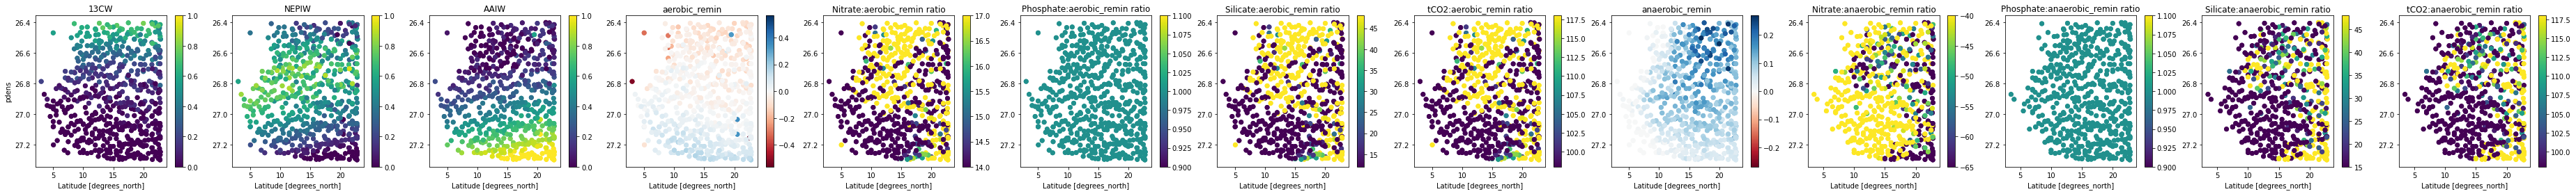

In [97]:
xaxis_colname="Latitude [degrees_north]"

yaxis_colname = "pdens"
print("Water mass fractions and deltaP")
plot_ompasoln_endmember_fractions(ompa_soln=ETNP_df_ompasoln,
                                  xaxis_colname=xaxis_colname,
                                  yaxis_colname=yaxis_colname)


Plot residuals

Residuals


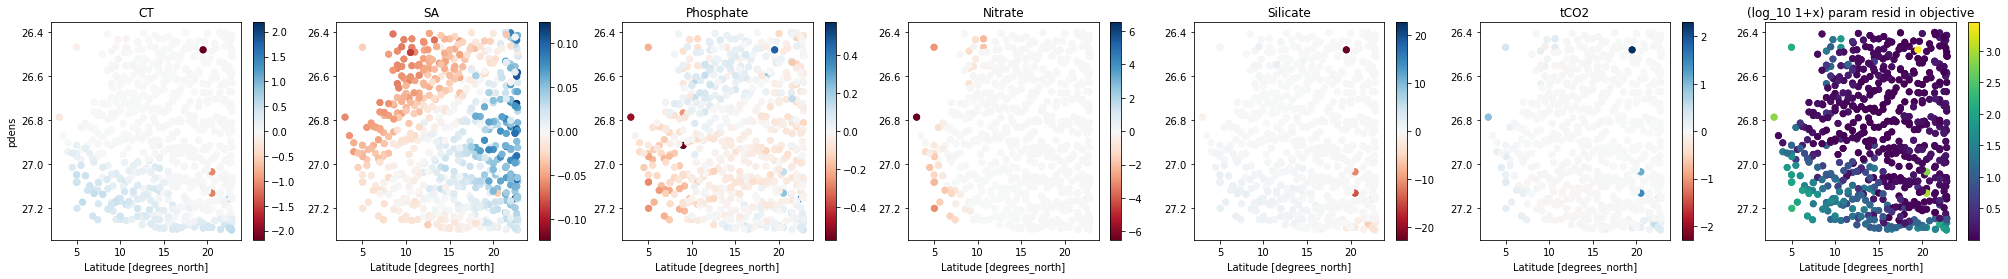

In [98]:
print("Residuals")
plot_ompasoln_residuals(ompa_soln=ETNP_df_ompasoln,
                        xaxis_colname=xaxis_colname,
                        yaxis_colname=yaxis_colname)

Output the pyompa sol'n




In [99]:

# ORIG_COLS_TO_INCLUDE = ["lat", "long", "pdens", "pressure", "nitrate", "oxygen", "phosphate",'conservative_temp', 'absolute_salinity']
ORIG_COLS_TO_INCLUDE = list(data_df.columns.values)
ETNP_df_ompasoln.export_to_csv(
    csv_output_name="ETNP_df_ompasoln.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)


writing to ETNP_df_ompasoln.csv


Starting sensitivity analysis
Don't forget to ask Avanti how to put this file into my github for the paper!

In [100]:
#Install gp15wmascripts
!pip uninstall -y gp15wma
%cd /content/
!rm -rf gp15wmascripts
!git clone https://github.com/nitrogenlab/gp15wmascripts
%cd /content/gp15wmascripts
!git checkout main
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import gp15wma
reload(gp15wma)

Found existing installation: gp15wma 0.1.0.0
Uninstalling gp15wma-0.1.0.0:
  Successfully uninstalled gp15wma-0.1.0.0
/content
Cloning into 'gp15wmascripts'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 248 (delta 13), reused 3 (delta 3), pack-reused 226
Receiving objects: 100% (248/248), 16.42 MiB | 24.88 MiB/s, done.
Resolving deltas: 100% (137/137), done.
/content/gp15wmascripts
Already on 'main'
Your branch is up to date with 'origin/main'.
commit 0f8be9e53d4dfdb510bd26abfe98a12fce38a942 (HEAD -> main, origin/main, origin/HEAD)
Author: rml54 <45828236+rml54@users.noreply.github.com>
Date:   Mon Apr 18 17:02:17 2022 -0400

    Update funcdump.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/gp15wmascripts
  DEPRECATION: A future pip version will change local packages to be built in-place without first copyi

/content


<module 'gp15wma' from '/usr/local/lib/python3.7/dist-packages/gp15wma/__init__.py'>

In [101]:
from gp15wma.sensitivity import BaseSensitivityAnalysis, OmpaArguments

from gp15wma.sensitivity import get_mean_and_stdev_skeletons


In [102]:
# print("mean")

def plot_ompasoln_residuals2(ompa_soln, xaxis_colname,
                             yaxis_colname, flip_y=True):
  pyompa.plotting.plot_residuals(
          param_residuals=ompa_soln.param_residuals,
          param_names=ompa_soln.param_names,
          xaxis_vals=ompa_soln.obs_df[xaxis_colname],
          xaxis_label=xaxis_colname,
          yaxis_vals=ompa_soln.obs_df[yaxis_colname],
          yaxis_label=yaxis_colname, flip_y=flip_y,
          perobs_weighted_resid_sq=None)

# plot_ompasoln_residuals2(ompa_soln=mean_skeleton,
#                                   xaxis_colname="Latitude [degrees_north]",
#                                   yaxis_colname="pdens")
# print("std")
# plot_ompasoln_residuals2(ompa_soln=std_skeleton,
#                                   xaxis_colname="Latitude [degrees_north]",
#                                   yaxis_colname="pdens")

In [103]:
# #Install endmember sensitivities

# !pip uninstall -y ETNP_stoich
# %cd /content/
# !rm -rf ETNP_stoich
# !git clone https://github.com/NatalyaEvans/ETNP_stoich/
# %cd /content/ETNP_stoich
# !git checkout main
# !git log -1
# !pip install .
# %cd /content/

# %reload_ext autoreload
# %autoreload 2
# from importlib import reload
# import pyompa_scripts
# reload(pyompa_scripts)

In [104]:
def perturb_endmember_df(df, variation_range, rng):
  new_df = OrderedDict([
      ("Params", df["Params"]) #endmember name column
  ])
  params_to_perturb = ["CT", "SA", "Phosphate", "Nitrate", "Silicate", "tCO2"]
  for param_name in params_to_perturb:
    values = list(df[param_name])
    new_values = [rng.uniform(value-variation_range[param_name],
                              value+variation_range[param_name])
                  for value in values]
    new_df[param_name] = new_values

  return pd.DataFrame(new_df)


def perturb_endmember_df_stoichiometrically(df, stoichiometry, rng,
                                            perturbation_limits_0, 
                                            scale_factor):
  #in Talia's project, pertubation_limits corresponds to phosphate which
  # has ratio 1 wrt to the converted param
  
  new_df = OrderedDict([
      ("Params", df["Params"]), #endmember name column and params that are carried through
      ("CT", df["CT"]),
      ("SA", df["SA"]),
  ])

  params_to_perturb = ["Phosphate", "Nitrate", "Silicate", "tCO2"]

  # print(sampled_perturbations)
  for param_name in params_to_perturb:
    values = list(df[param_name])

    # sample a different perturbation for each row in the data frame
    sampled_perturbations_0 = [rng.uniform(perturbation_limits_0[0], # remin 1
                                    perturbation_limits_0[1])
                              for i in range(len(df))]
    sampled_perturbations_1 = [rng.uniform(perturbation_limits_0[0]*scale_factor, # remin 2
                                       perturbation_limits_0[1]*scale_factor)
                                for i in range(len(df))]

    new_values = [value + sampled_perturbation0*(stoichiometry[0].conversion_ratios[0][param_name] +
                        stoichiometry[0].conversion_ratios[1][param_name])/2
                        for sampled_perturbation0, value in
                        zip(sampled_perturbations_0, values)]
                  
    new_values2 = [value + sampled_perturbation1*(stoichiometry[1].conversion_ratios[0][param_name] +
                        stoichiometry[1].conversion_ratios[1][param_name])/2
                        for sampled_perturbation1, value in
                        zip(sampled_perturbations_1, new_values)]

    new_df[param_name] = new_values2


  return pd.DataFrame(new_df)

# perturb_endmember_df_stoichiometrically(
#     endmembers_df,
#     stoichiometry=convertedparamgroups, # now inputting the whole thing
#     perturbation_limits_0=(-0.15, 0.15),
#     scale_factor=0.1/0.15,
#     rng = np.random.RandomState(1234))

Sensitivity with regards to endmembers

In [105]:
#Prepare the varying OMPA arguments

rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 10
base_endmembers = endmembers_df

#sample varying parameter weightings
sampled_endmembers = []
for i in range(num_samples):
    sampled_endmembers.append(perturb_endmember_df_stoichiometrically(
    endmembers_df,
    # stoichiometry=convertedparamgroups[0].conversion_ratios[1],
    stoichiometry=convertedparamgroups,
    perturbation_limits_0=(-0.075, 0.075),
    scale_factor=0.1/0.15,
    rng=rng))
    print("Iteration:", i)
    display(sampled_endmembers[-1])

##write out the various sampled weightings
#open("sampled_endmembers.json", "w").write(
#    json.dumps(sampled_endmembers, indent=4))

varying_arguments_list = [OmpaArguments(
        constructor_arguments={},
        solve_arguments={"endmember_df": df}) for df in sampled_endmembers]

ETNP_weighting_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "param_weightings": paramweightings,
          "obs_df": ETNP_df_ompasoln.obs_df,
          "endmembername_to_usagepenaltyfunc": usage_penalty,
          "param_names": ETNP_df_ompasoln.param_names,
          "convertedparam_groups": convertedparamgroups
          },
        solve_arguments={
            "endmember_name_column": "Params",
            "batch_size": 100
        }
    ))

!mkdir endmembers_sensitivity
ompa_solns = ETNP_weighting_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="endmembers_sensitivity",
    export_settings={"orig_cols_to_include":ORIG_COLS_TO_INCLUDE})

Iteration: 0


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.337264  28.706633  26.418351  2252.666070
1  NEPIW   9.47  34.78   2.696314  37.048312  34.826871  2271.612905
2   AAIW   5.53  34.70   3.097918  44.269950  81.564499  2319.394452

Iteration: 1


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.448844  33.928445  25.423910  2240.026905
1  NEPIW   9.47  34.78   2.654390  34.379233  34.385303  2267.900971
2   AAIW   5.53  34.70   3.121390  42.838441  82.425138  2325.196399

Iteration: 2


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.340170  28.889624  23.475006  2242.106018
1  NEPIW   9.47  34.78   2.657039  34.149476  34.051425  2280.384526
2   AAIW   5.53  34.70   3.022461  42.352657  82.176124  2317.850751

Iteration: 3


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.390741  29.463153  27.369661  2246.247110
1  NEPIW   9.47  34.78   2.582744  32.940952  32.705488  2270.896115
2   AAIW   5.53  34.70   3.092968  42.403159  84.592961  2323.484877

Iteration: 4


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.377474  33.742642  22.698195  2249.712879
1  NEPIW   9.47  34.78   2.724592  38.203647  35.755751  2270.331773
2   AAIW   5.53  34.70   3.084379  43.800129  84.219951  2322.768247

Iteration: 5


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.398914  33.152998  25.839710  2248.371264
1  NEPIW   9.47  34.78   2.689126  36.894535  34.459940  2276.260528
2   AAIW   5.53  34.70   3.137014  41.742992  81.199221  2315.665909

Iteration: 6


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.256960  34.359566  26.792575  2257.767564
1  NEPIW   9.47  34.78   2.630197  34.540156  34.785344  2276.804725
2   AAIW   5.53  34.70   3.141569  41.158884  85.018436  2330.469335

Iteration: 7


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.400191  28.955436  26.620600  2243.104187
1  NEPIW   9.47  34.78   2.703299  34.661886  33.654885  2275.259202
2   AAIW   5.53  34.70   3.181154  41.840449  83.735179  2318.567196

Iteration: 8


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.292685  29.901551  26.220922  2241.992450
1  NEPIW   9.47  34.78   2.695996  35.965581  34.148570  2275.633152
2   AAIW   5.53  34.70   3.034365  42.063711  81.095091  2321.756223

Iteration: 9


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.395343  31.497726  24.630080  2248.536900
1  NEPIW   9.47  34.78   2.624609  37.214275  34.303448  2271.042529
2   AAIW   5.53  34.70   3.078299  44.373007  83.119215  2320.140379

mkdir: cannot create directory ‘endmembers_sensitivity’: File exists
On varying argument 0 out of 10
varying arguments: OMPAArguments(constructor_arguments={}, solve_arguments={'endmember_df':   Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.337264  28.706633  26.418351  2252.666070
1  NEPIW   9.47  34.78   2.696314  37.048312  34.826871  2271.612905
2   AAIW   5.53  34.70   3.097918  44.269950  81.564499  2319.394452})
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['CT', 'SA', 'Phosphate', 'Nitrate', 'Silicate', 'tCO2']
param weighting: [12.  8.  6.  4.  2.  4.]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 100 out of 1220
status: optimal
optimal value 111077.00642800878
Original weighted sum squares: 111077.00642800878
Post fix weighted sum squared: 111077.60107766023
On example 100 to 200 out of 1220
status: optimal
optimal val

mean


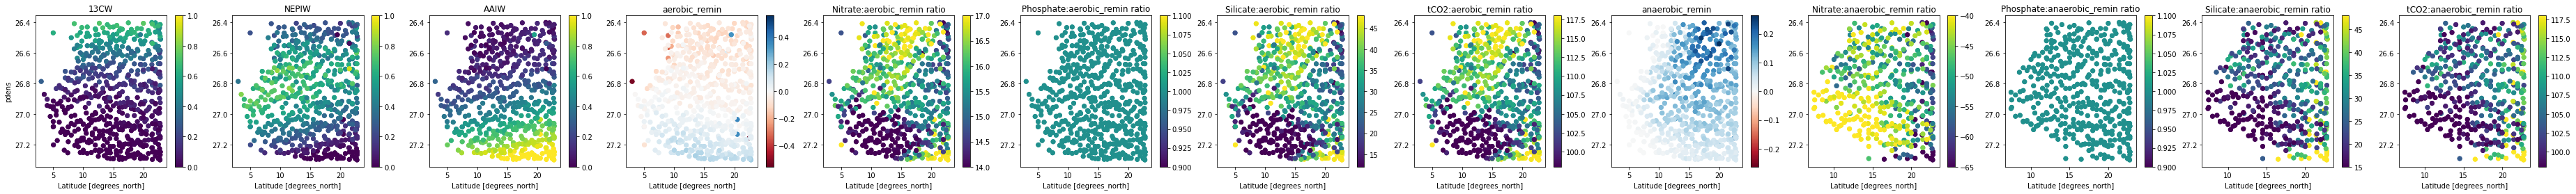

std


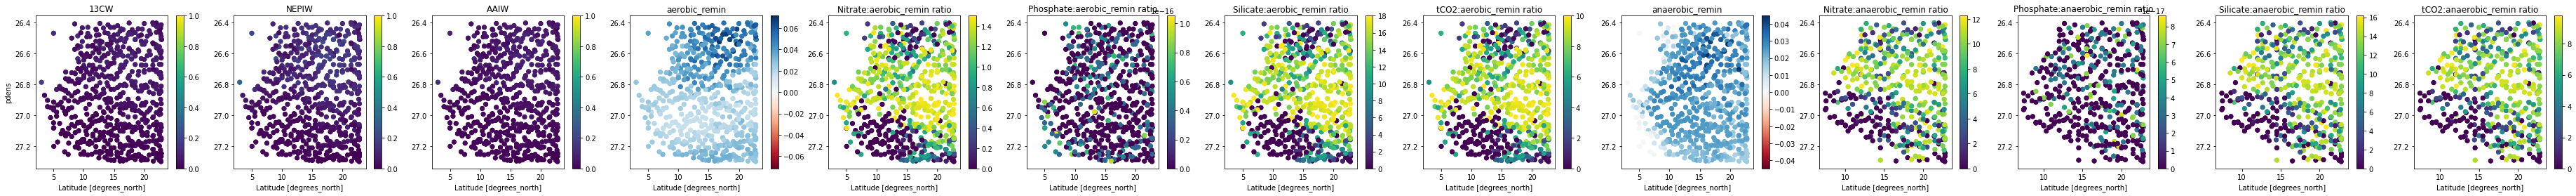

In [106]:
#plot the solutions

mean_skeleton_endmembers, std_skeleton_endmembers = get_mean_and_stdev_skeletons(ompa_solns=ompa_solns)

print("mean")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=mean_skeleton_endmembers,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")
print("std")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=std_skeleton_endmembers,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")

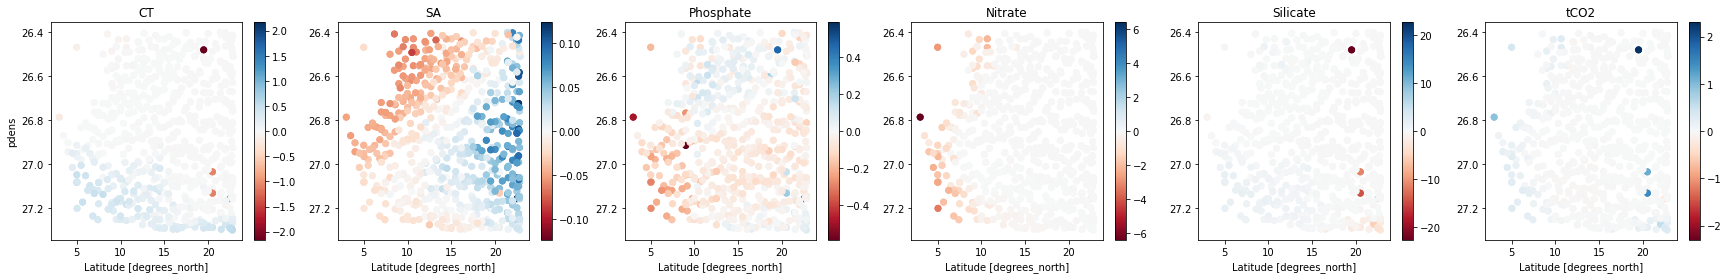

std


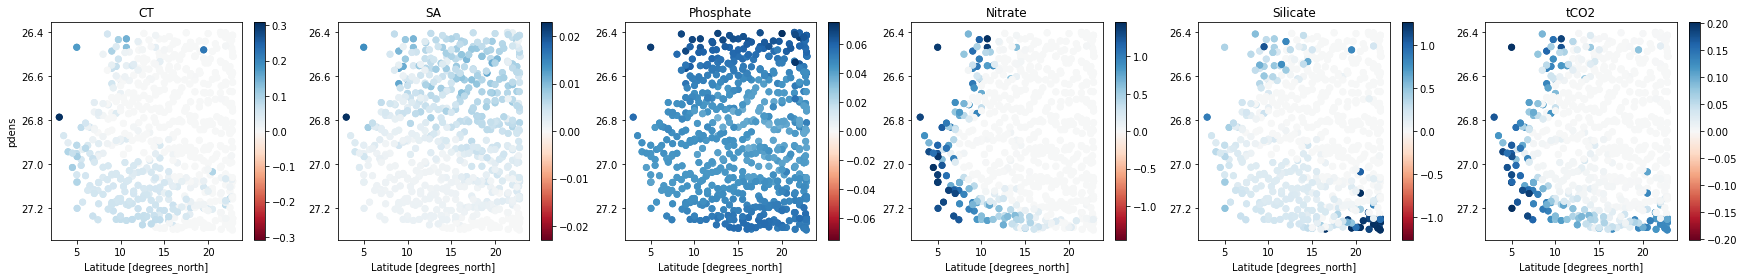

In [107]:
plot_ompasoln_residuals2(ompa_soln=mean_skeleton_endmembers,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")
print("std")
plot_ompasoln_residuals2(ompa_soln=std_skeleton_endmembers,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")

In [108]:
# ###uncomment below to export csv with senstivity analysis info###

# ORIG_COLS_TO_INCLUDE = ORIG_COLS_TO_INCLUDE
# mean_skeleton_endmembers.export_to_csv(
#     csv_output_name="mean_skeleton_endmembers.csv",
#     orig_cols_to_include=ORIG_COLS_TO_INCLUDE)
# std_skeleton_endmembers.export_to_csv(
#     csv_output_name="std_skeleton_endmembers.csv",
#     orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

Sensitivity with regards to weightings

In [109]:
#Prepare the varying OMPA arguments

rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 20
base_weighting = paramweightings

#sample varying parameter weightings
sampled_weightings = []
for i in range(num_samples):
    rand_weighting = dict([
        (key, rng.uniform(value*0.8, value*1.2))
        for key,value in base_weighting.items()
    ])
    sampled_weightings.append(rand_weighting)

#write out the various sampled weightings
open("sampled_weightings.json", "w").write(
    json.dumps(sampled_weightings, indent=4))

varying_arguments_list = [OmpaArguments(
        constructor_arguments={"param_weightings": rand_weighting},
        solve_arguments={}) for weighting in sampled_weightings]

ETNP_weighting_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "obs_df": ETNP_df_ompasoln.obs_df,
          "endmembername_to_usagepenaltyfunc": usage_penalty,
          "param_names": ETNP_df_ompasoln.param_names,
          "convertedparam_groups": convertedparamgroups
          },
        solve_arguments={
            "endmember_df": endmembers_df,
            "endmember_name_column": "Params",
            "batch_size": 100
        }
    ))

!mkdir param_weightings_sensitivity
ompa_solns = ETNP_weighting_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="param_weightings_sensitivity",
    export_settings={"orig_cols_to_include":ORIG_COLS_TO_INCLUDE})


mkdir: cannot create directory ‘param_weightings_sensitivity’: File exists
On varying argument 0 out of 20
varying arguments: OMPAArguments(constructor_arguments={'param_weightings': {'CT': 13.819531975270444, 'SA': 7.208370416148897, 'Phosphate': 5.635221102886431, 'Nitrate': 3.492141970528494, 'tCO2': 4.642873682193587, 'Silicate': 2.165222530537438}}, solve_arguments={})
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['CT', 'SA', 'Phosphate', 'Nitrate', 'Silicate', 'tCO2']
param weighting: [13.81953198  7.20837042  5.6352211   3.49214197  2.16522253  4.64287368]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 100 out of 1220
status: optimal
optimal value 84820.97901673203
Original weighted sum squares: 84820.97901673203
Post fix weighted sum squared: 84825.61055084896
On example 100 to 200 out of 1220
status: optimal
optimal value 3224.1360927064684
Original weighted sum squar

mean


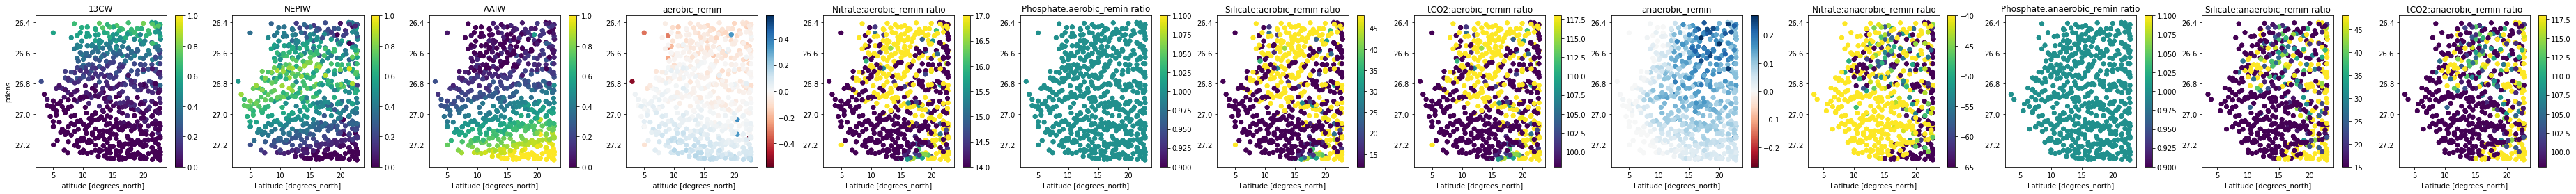

std


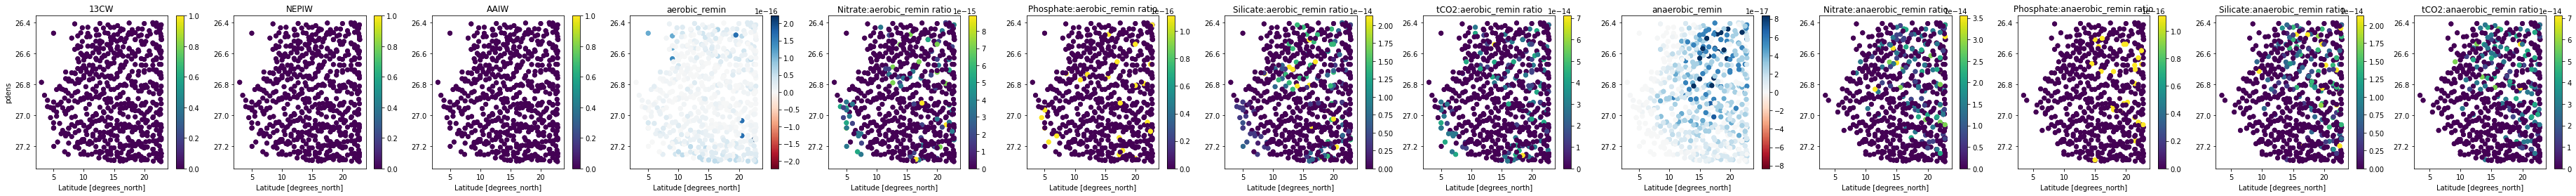

In [110]:
#plot the solutions

mean_skeleton_weightings, std_skeleton_weightings = get_mean_and_stdev_skeletons(ompa_solns=ompa_solns)

print("mean")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=mean_skeleton_weightings,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")
print("std")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=std_skeleton_weightings,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")

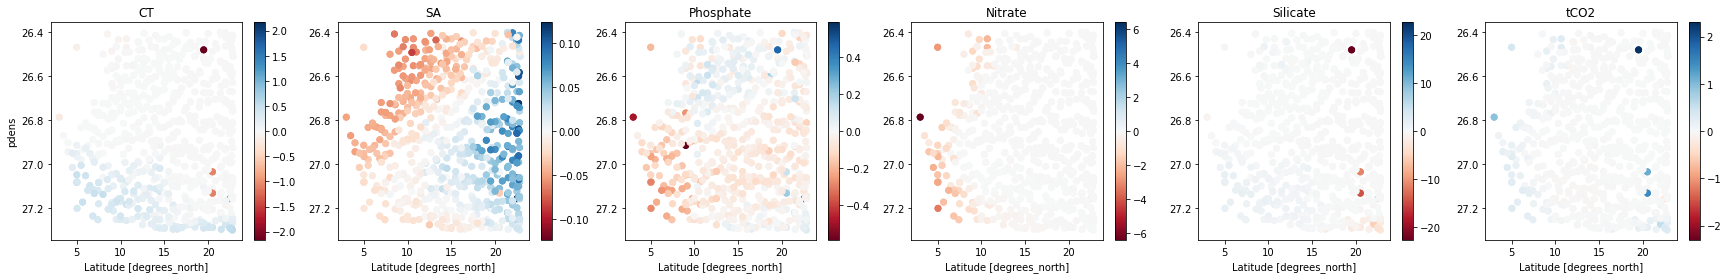

std


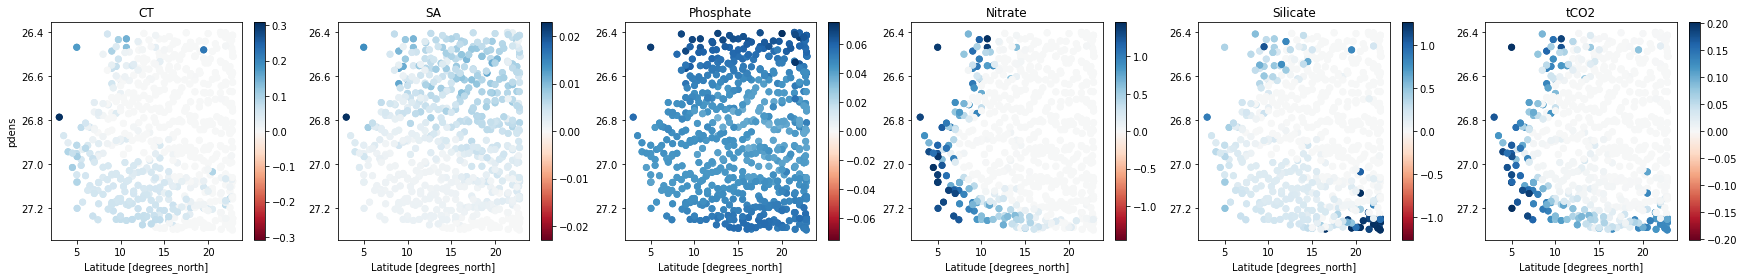

In [111]:
plot_ompasoln_residuals2(ompa_soln=mean_skeleton_endmembers,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")
print("std")
plot_ompasoln_residuals2(ompa_soln=std_skeleton_endmembers,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")

In [112]:
###uncomment below to export csv with senstivity analysis info###

%cd "/content/drive/MyDrive/pyompa/ETNP WOD pyompa"

###uncomment below to export csv with senstivity analysis info###

ORIG_COLS_TO_INCLUDE = ORIG_COLS_TO_INCLUDE
mean_skeleton_endmembers.export_to_csv(
    csv_output_name="mean_skeleton_endmembers.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)
std_skeleton_endmembers.export_to_csv(
    csv_output_name="std_skeleton_endmembers.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

mean_skeleton_weightings.export_to_csv(
    csv_output_name="mean_skeleton_weightings.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)
std_skeleton_weightings.export_to_csv(
    csv_output_name="std_skeleton_weightings.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

/content/drive/MyDrive/pyompa/ETNP WOD pyompa
writing to mean_skeleton_endmembers.csv
writing to std_skeleton_endmembers.csv
writing to mean_skeleton_weightings.csv
writing to std_skeleton_weightings.csv
